# WGI Regional Fact Sheets: continental maps

Map insets for IPCC AR6 WGI [regional fact sheets](https://www.ipcc.ch/report/ar6/wg1/resources/factsheets/)

Author: Mathias Hauser

In [1]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Tuple

import cartopy.crs as ccrs
import geopandas as gp
import matplotlib as mpl
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import mplotutils as mpu
import numpy as np
import regionmask

import conf

In [2]:
FIGURE_FOLDER = ("RegionalFactSheets", "ContinentalRegions")

In [3]:
ar6 = regionmask.defined_regions.ar6.all

ar6_ocean = regionmask.defined_regions.ar6.ocean

### Regions

* list all AR6 regions part of each continent

In [4]:
REGIONS = {
    "Africa": ["MED", "SAH", "WAF", "CAF", "NEAF", "SEAF", "WSAF", "ESAF", "MDG"],
    "Asia": ["WSB", "ESB", "RFE", "WCA", "ECA", "TIB", "EAS", "ARP", "SAS", "SEA"],
    "Australasia": ["NAU", "CAU", "SAU", "EAU", "NZ"],
    "SouthAmerica": ["SCA", "NWS", "NSA", "SAM", "NES", "SWS", "SES", "SSA"],
    "Europe": ["NEU", "WCE", "MED", "EEU"],
    "NorthAmerica": ["NWN", "NEN", "WNA", "CNA", "ENA", "NCA", "SCA", "CAR"],
    "Ocean": [
        "NPO",
        "EPO",
        "SPO",
        "ARO",
        "NAO",
        "EAO",
        "SAO",
        "SOO",
        "SIO",
        "ARS",
        "BOB",
        "EIO",
    ],
}

### Find unused regions

double check that no region was forgotten

In [5]:
all_abbrevs = [item for sublist in REGIONS.values() for item in sublist]
len(all_abbrevs)

not_used = set(ar6.abbrevs) - set(all_abbrevs)
ar6[not_used]

<regionmask.Regions>
Name:     AR6 reference regions
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)

Regions:
 0 GIC Greenland/Iceland
28 RAR    Russian-Arctic
44 EAN      E.Antarctica
45 WAN      W.Antarctica

[4 regions]

## Load monsoon regions

In [6]:
fN = "zip://../data/MonsoonRegions/monsoons_shapefile.zip"

monsoon_gdf = gp.read_file(fN)

# create a mask with 0.5° resolution
# to smooth out some the edges (the polygon is from a raster)
lon = np.arange(0.25, 360, 0.5)
lat = np.arange(87.75, -90, -0.5)
monsoon_mask = regionmask.mask_geopandas(monsoon_gdf, lon, lat)
monsoon_mask = monsoon_mask.where(monsoon_mask.isnull(), 1)

# add a cyclic poing for the contourf
monsoon_mask = mpu.cyclic_dataarray(monsoon_mask)

## Helper functions

allow to offset text elements, see https://github.com/regionmask/regionmask/issues/235

In [7]:
def find_by_str(ax, s):
    """find plot text elements by their text"""

    out = list()
    for t in ax.texts:
        if t.get_text() == s:
            out.append(t)
    return out


def offset_text(ax, s, offset):
    """shift a text box by an offset"""
    texts = find_by_str(ax, s)

    for t in texts:
        p = np.array(t.get_position())
        t.set_position(p + offset)

In [8]:
def plot_region(
    region: "RegionSettings", add_ocean: bool = True, add_land: bool = False
):
    """plot continental region
    
    Parameters
    ----------
    region : RegionSettings
        Dataclass containg the config for each continental region.
    add_ocean : bool, default: True
        Whether to color the ocean in blue.
    add_land : bool, default False
        Whether to color the land in a light green.
    
    
    """

    import cartopy.feature as cfeature

    # text settings
    text_kws = dict(
        color="0.1",
        fontsize=region.fontsize,
        bbox=dict(pad=region.pad, color="none", zorder=0, alpha=0),
        zorder=3,
        path_effects=[pe.withStroke(linewidth=1.25, foreground="w")],
    )

    ocean_kws = land_kws = None
    if add_ocean:
        ocean_kws = dict(
            facecolor=cfeature.COLORS["water"], zorder=0.9, edgecolor="none"
        )
    if add_land:
        land_kws = dict(facecolor=cfeature.COLORS["land"], zorder=0.0, edgecolor="none")

    line_kws = dict(lw=region.lw, zorder=2.1)

    reg = region.region

    # create the figure
    f, ax = plt.subplots(
        subplot_kw=dict(
            projection=ccrs.Robinson(central_longitude=region.central_longitude)
        )
    )

    # regionmask plot
    reg.plot(
        ax=ax,
        text_kws=text_kws,
        label="abbrev",
        label_multipolygon="all",
        line_kws=line_kws,
        add_ocean=add_ocean,
        ocean_kws=ocean_kws,
        add_land=add_land,
        land_kws=land_kws,
        resolution="110m",
    )

    # maybe shift text labels (so they don't overlapp)
    for key, offset in region.offsets.items():
        offset_text(ax, key, offset)

    # set axes borders
    dx = region.dx
    dy = region.dy
    f.subplots_adjust(left=dx, right=1 - dx, bottom=dy, top=1 - dy)

    mpu.set_map_layout(ax, region.width)

    f.canvas.draw()

    if region.plot_monsoon:
        plot_monsoon(
            ax,
            True,
            fontsize=region.fontsize,
            legend_kwargs=region.legend_kwargs,
            label=region.monsoon_label,
        )

    return ax

In [9]:
def plot_monsoon(ax, mask=True, fontsize=9, legend_kwargs=None, label="Monsoon Region"):
    """add monsoon regions

    ax : geoaxes
        Geoaxes to plot the monsoon region on.
    mask : bool, default: True
        Whether to plot the monsoon region from the
        mask or from the GeoDataFrame
    fontsize : int
        Font size of the labels.
    legend_kwargs : mapping
        Passed to the legend.
    label : str, default: "Monsoon Region"
        The label of the legend.
    """

    # read current lims
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    width_inches = ax.figure.get_size_inches()[0].item()

    # plot the monsoon regions
    if mask:
        monsoon_mask.plot.contourf(
            ax=ax,
            levels=[0.95, 1.05],
            colors=["0.8", "none"],
            add_colorbar=False,
            transform=ccrs.PlateCarree(),
            zorder=0.7,
        )

    else:
        monsoon_gdf.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            color="0.8",
            zorder=0.7,
        )

    legend_kwargs = {} if legend_kwargs is None else legend_kwargs

    # use same fontsize as labels, unless one is given in legend_kwargs
    legend_kwargs["fontsize"] = legend_kwargs.get("fontsize", fontsize)

    # add legend
    proxy = [plt.Rectangle((0, 0), 1, 1, fc="0.8")]
    legend = ax.legend(proxy, [label], **legend_kwargs)
    plt.setp(legend.get_texts(), color="0.2")

    # make the legend frame (bbox) edgecolor intransparent
    # but the facecolor should be transparent
    f = legend.get_frame()
    f.set_alpha(None)
    f.set_edgecolor((0.8, 0.8, 0.8, 1))
    f.set_facecolor((1.0, 1.0, 1.0, 0.8))
    f.set_lw(0.75)

    # reset lims
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    mpu.set_map_layout(ax, width_inches * 2.54)

    ax.figure.canvas.draw()

In [10]:
mpu.set_map_layout

<function mplotutils.mpl_utils.set_map_layout(axes, width=17.0, nrow=None, ncol=None)>

In [11]:
@dataclass
class RegionSettings:
    """container to store settings for each region
    
    Parameters
    ----------
    name : str
        Name of the continental region.
    abrevs : list[str]
        List of the regions for that is part of
        the continent.
    width : float
        Width of the figure in cm.
    fontsize : float
        Font size.
    pad : float, default: 0.1
        Padding of text bbox.
    lw : float, default: 0.5
        Linewidth of the region outlines.
    dx : int, default: 0.01
        Padding between left & right figure edge and axes.
    dy : int, default: 0.01
        Padding between top & bottom figure edge and axes.
    monsoon_label : str, default: "Monsoon Region"
        Name of the monsoon region in the legend.
    offsets : mapping, default: None
        Mapping of region names and offset of the region
        labels relative to their original position.
    legend_kwargs : mapping, default: None
        Keyword arguments passed to the legend,
    """

    name: str
    abbrevs: List[str]
    width: float
    fontsize: float
    plot_monsoon: bool
    pad: float = 0.1
    lw: float = 0.5
    dx: int = 0.01
    dy: int = 0.01
    monsoon_label: str = "Monsoon Region"

    offsets: Dict[str, Tuple[float, float]] = field(default_factory=dict)
    legend_kwargs: Dict[str, Any] = field(default_factory=dict)

    # private property
    _central_longitude: float = None
        
    @property
    def region(self):
        return ar6[self.abbrevs]

    @property
    def central_longitude(self):
        """use the mid lon extension as central longitude"""

        if self._central_longitude is None:

            xmin, _, xmax, _ = self.region.bounds_global
            self._central_longitude = (xmin + xmax) / 2

        return self._central_longitude

## Define region params

In [12]:
default_handlelength = mpl.rcParamsDefault["legend.handlelength"]
default_handleheight = mpl.rcParamsDefault["legend.handleheight"]

### Africa

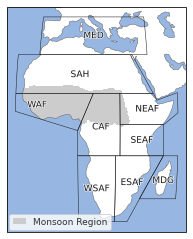

In [13]:
Africa = RegionSettings(
    "Africa",
    REGIONS["Africa"],
    width=6.44,
    fontsize=9,
    plot_monsoon=True,
    offsets={"WAF": (-8, 1)},
    legend_kwargs={
        "loc": "lower left",
        "handlelength": default_handlelength * 0.75,
        "borderaxespad": 0.2,
    },
)


region = Africa

# ====

ax = plot_region(region)

fN = conf.figure_filename("Africa", *FIGURE_FOLDER)

plt.savefig(fN + ".pdf")
plt.savefig(fN + ".png", dpi=300, facecolor="w")

### Australasia

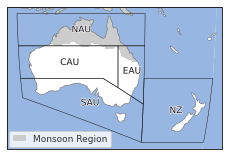

In [14]:
Australasia = RegionSettings(
    "Australasia",
    REGIONS["Australasia"],
    width=7.75,
    fontsize=9,
    plot_monsoon=True,
    legend_kwargs={
        "loc": "lower left",
        "handlelength": default_handlelength * 0.75,
        "borderaxespad": 0.2,
    },
)


region = Australasia

# ====

ax = plot_region(region)


fN = conf.figure_filename("Australasia", *FIGURE_FOLDER)

plt.savefig(fN + ".pdf")
plt.savefig(fN + ".png", dpi=300, facecolor="w")

### Central and South America

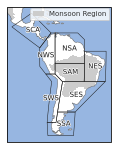

In [15]:
SouthAmerica = RegionSettings(
    "Cental and South America",
    REGIONS["SouthAmerica"],
    width=3.73,
    fontsize=7,
    plot_monsoon=True,
    legend_kwargs={
        "handlelength": default_handlelength * 0.75,
        "borderaxespad": 0.2,
    },
    offsets={"NWS": (-1.75, 0), "SWS": (-2.5, 0), "SSA": (1, 1)},
)


region = SouthAmerica

# ====

ax = plot_region(region)

fN = conf.figure_filename("CentralSouthAmerica", *FIGURE_FOLDER)

plt.savefig(fN + ".pdf")
plt.savefig(fN + ".png", dpi=300, facecolor="w")

### Europe

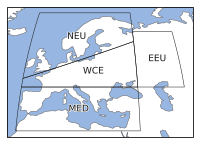

In [16]:
Europe = RegionSettings(
    "Europe",
    REGIONS["Europe"],
    width=6.68,
    fontsize=9,
    plot_monsoon=False,
)

region = Europe

# ====

ax = plot_region(region)

fN = conf.figure_filename("Europe", *FIGURE_FOLDER)
plt.savefig(fN + ".pdf")
plt.savefig(fN + ".png", dpi=300, facecolor="w")

### Asia

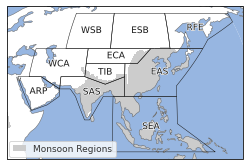

In [17]:
Asia = RegionSettings(
    "Asia",
    REGIONS["Asia"],
    width=8.5,
    fontsize=9,
    plot_monsoon=True,
    monsoon_label="Monsoon Regions",
    legend_kwargs={
        "fontsize": 9,
        "loc": "lower left",
        "handlelength": default_handlelength * 0.75,
        "borderaxespad": 0.2,
    },
)


region = Asia

# ====

ax = plot_region(region)

fN = conf.figure_filename("Asia", *FIGURE_FOLDER)
plt.savefig(fN + ".pdf")
plt.savefig(fN + ".png", dpi=300, facecolor="w")

### North and Central America

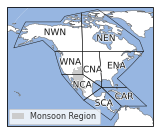

In [18]:
NorthAmerica = RegionSettings(
    "North and Central America",
    REGIONS["NorthAmerica"],
    width=5.26,
    fontsize=9,
    plot_monsoon=True,
    legend_kwargs={
        "loc": "lower left",
        "handlelength": default_handlelength * 0.75,
        "borderaxespad": 0.2,
        "fontsize": 8,
    },
    offsets={"CNA": (0, -2.5), "NEN": (0, -5)},
)

region = NorthAmerica

# ====

ax = plot_region(region)

fN = conf.figure_filename("NortAmerica", *FIGURE_FOLDER)
plt.savefig(fN + ".pdf")
plt.savefig(fN + ".png", dpi=300, facecolor="w")

### Ocean

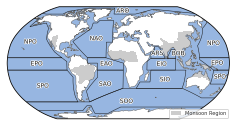

In [19]:
Ocean = RegionSettings(
    "Ocean",
    REGIONS["Ocean"],
    width=8,
    fontsize=6,
    plot_monsoon=True,
    legend_kwargs={
        "loc": "lower right",
        #         "handlelength": default_handlelength * 0.75,
        "borderaxespad": 0.2,
        "fontsize": 5,
    },
    offsets={"BOB": (10, 1), "ARO": (10, -5)},
)

# ====

region = Ocean

ax = plot_region(region)

fN = conf.figure_filename("Ocean", *FIGURE_FOLDER)
plt.savefig(fN + ".pdf")
plt.savefig(fN + ".png", dpi=300, facecolor="w")

### Global

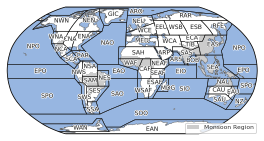

In [20]:
Global = RegionSettings(
    "Global",
    ar6.abbrevs,
    width=9,
    fontsize=6,
    plot_monsoon=True,
    legend_kwargs={
        "loc": "lower right",
        "borderaxespad": 0.2,
    },
    offsets={
        "ARO": (8, -5),
        "WAN": (0, -1),
        "SES": (0, 2.5),
        "SWS": (0, -3.5),
        "NES": (2, 0),
        "SAM": (0, 0.5),
        "NSA": (0, 3),
        "SSA": (0, -1.5),
        "ENA": (0, 3),
        "WNA": (-5, 0),
        "MDG": (6, -3),
        "ESAF": (0, 5),
        "WSAF": (0, -3),
    },
)

region = Global


# ====

ax = plot_region(region)


# remove second RAR text label
t = find_by_str(ax, "RAR")
t[1].remove()


fN = conf.figure_filename("Global", *FIGURE_FOLDER)
plt.savefig(fN + ".pdf")
plt.savefig(fN + ".png", dpi=300, facecolor="w")